# The Dataset
## Importing the Data
The dataset contains 6 classes of images: `building`, `forest`, `glacier`, `mountain`, `sea`, and `street`. We decided to delete the class `street` and it's corresponding pictures to simplify the learning process. The images are divided into folders with their respective labels. We used the image_dataset_from_directory method of Keras to convert the images into a TensorFlow dataset object for training.

In [58]:
# TODO: Remove this link https://www.kaggle.com/code/dwight9339/image-classification-exercise

# import cv2
import random
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [59]:
training_img_path = "./dataset/seg_train/seg_train/"
testing_img_path = "./dataset/seg_test/seg_test/"

batch_size = 32
img_size = 50
seed = 42

train_ds = keras.utils.image_dataset_from_directory(
    training_img_path,
    #subset="training",
    labels="inferred",
    seed=seed,
    image_size=(img_size, img_size),
    batch_size=batch_size
)
val_ds = keras.utils.image_dataset_from_directory(
    testing_img_path,
    #subset="validation",
    labels="inferred",
    seed=seed,
    image_size=(img_size, img_size),
    batch_size=batch_size
)

Found 11652 files belonging to 5 classes.
Found 2499 files belonging to 5 classes.


Let's see the first few images of the training dataset.

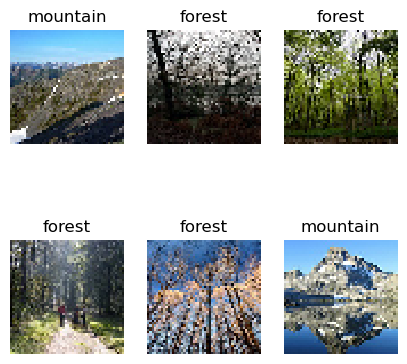

In [60]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5))
sample_images = []
for images, labels in train_ds.take(1):
  for i in range(6):
    ax = plt.subplot(2, 3, i + 1)
    sample_images.append((images[i], labels[i]))
    plt.imshow(images[i].numpy().astype("uint8"), interpolation="nearest")
    plt.title(train_ds.class_names[labels[i]])
    plt.axis("off")

# Underfitting Model
We will create a model that is too simple and won't describe the data accurately enough.

In this case, we can see from the learning curves that the model is indeed underfitting. Both the training and validation accuracy curves plateau at a low value, indicating that the model is not learning the patterns in the data well enough.

## Building the Model
TODO: STILL CORRECT?

We start off with a convolutional layer that'll import / rescale the images to `img_size`, using the relu activation function (for all the convolution layers). Running a kernel of 3x3 over each image 16 times. `padding=same` is reffering to the padding of the image (needed because of the kernel) being filled with zeros.

Following that is another convolution layer and max pooling layer. Next, the image will be flattened into a vector, which is ready to be fed to the following dense layer, having dropout applied to it. By applying dropout, we make sure the model does not learn too much, and therefore prevent overfitting (for this model). We also applied dropout to the first convolutional layer.

The last dense layer represents the output layer, having a shared softmax activation layer to determine the probabilities of the 5 different classes.

In [61]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential()

model.add(Conv2D(16, (3,3), input_shape=(img_size,img_size,3), activation='relu', padding='same'))
#model.add(Dropout(0.6))
model.add(MaxPooling2D())

model.add(Conv2D(8, (3,3), activation='relu', padding='same'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(8, activation='relu'))
#model.add(Dropout(0.6))
model.add(Dense(5, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [62]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 50, 50, 16)        448       
_________________________________________________________________
dropout_10 (Dropout)         (None, 50, 50, 16)        0         
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 25, 25, 16)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 25, 25, 8)         1160      
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 12, 12, 8)         0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 8)               

## Training the Model
Relatively high number of epochs is used to visualize the plateau-effect sufficiently.

In [63]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20
)

Epoch 1/20
365/365 [==============================] - 6s 17ms/step - loss: 2.5334 - accuracy: 0.2090 - val_loss: 1.6079 - val_accuracy: 0.2101
Epoch 2/20
357/365 [============================>.] - ETA: 0s - loss: 1.6086 - accuracy: 0.2150

KeyboardInterrupt: 

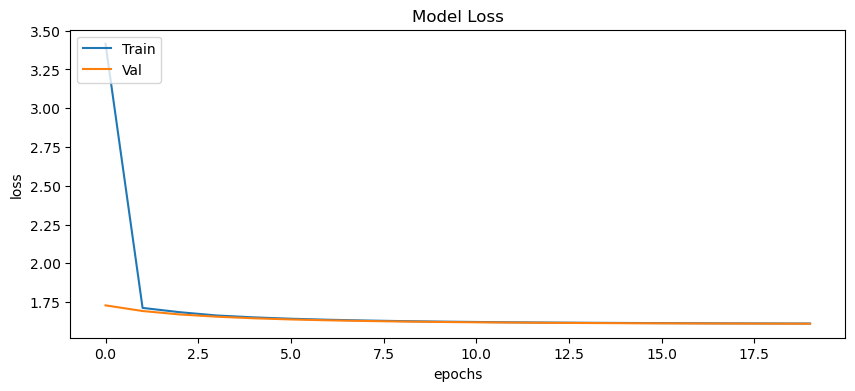

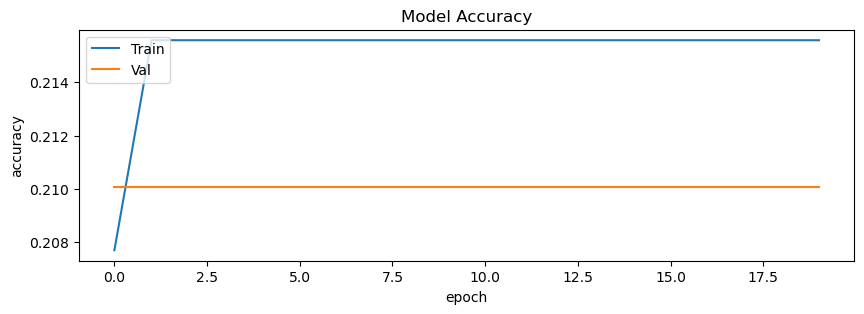

In [ ]:
%run rueegg_wissiak_model_visualization.ipynb

In [ ]:
%run rueegg_wissiak_model_evaluation.ipynb

NameError: name 'test_generator' is not defined

NameError: name 'test_generator' is not defined